# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).


**Note**: Make sure you make a validation split of your ID dataset for testing.

In [2]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [3]:
import torch
import torchvision
import os
from torchvision.datasets import FakeData
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
from sklearn import metrics
import random


In [4]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.cuda.is_available()

True

In [5]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

# In Distribution (ID) data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) # ID
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers= True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers= True)


# Out Of Distribution (OOD) data: Fake (noisy) data
fakeset = FakeData(size=1000, image_size=(3, 32, 32), transform=transform) # OOD
fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers= True)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


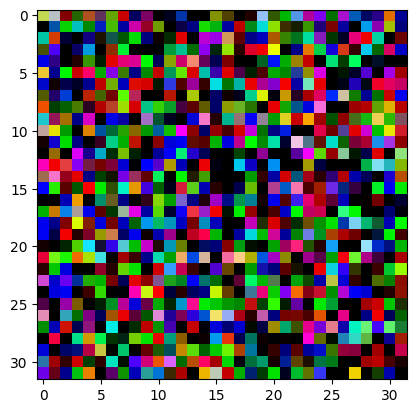

In [6]:
for data in fakeloader:
    x, y = data
    plt.imshow(x[0,:].permute(1,2,0))
    break

x.shape, trainset.classes[y[0]]

trainset.classes
class_dict = {class_name:id_class for id_class, class_name in enumerate(trainset.classes)} 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].


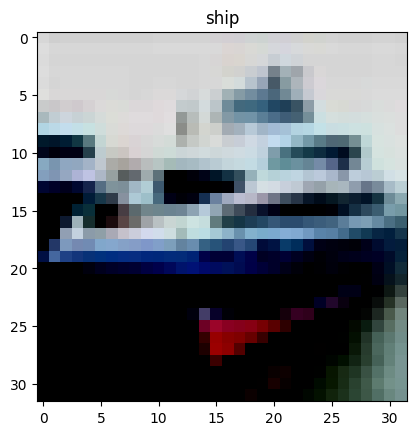

In [7]:
idx = 1
for data in testloader:
    x, y = data
    plt.title(trainset.classes[y[idx]])
    plt.imshow(x[idx,:].permute(1,2,0))
    break

In [55]:
from src.OOD_detection import CNN
from src.trainer import Trainer, EarlyStopping

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
NUM_CLASSES = 10


early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=5,         
    mode='min'          
)


trainer = Trainer(
    model=model,
    train_dl=trainloader,
    val_dl=testloader,
    optimizer=optimizer,
    criterion=criterion,
    num_classes=NUM_CLASSES,
    device=device,
    callbacks=[early_stopping_callback] 

)

epochs = 50
history = trainer.fit(epochs)

EarlyStopping enabled. Monitoring 'val_loss' with patience=5.
Starting training for 50 epochs on device 'cuda'...


Epoch 1/50 | Train Loss: 1.7598 | Val Loss: 1.5577 | Val Acc: 0.4412


Epoch 2/50 | Train Loss: 1.4448 | Val Loss: 1.3786 | Val Acc: 0.5014


Epoch 3/50 | Train Loss: 1.3093 | Val Loss: 1.2813 | Val Acc: 0.5438


Epoch 4/50 | Train Loss: 1.2021 | Val Loss: 1.1783 | Val Acc: 0.5766


Epoch 5/50 | Train Loss: 1.1165 | Val Loss: 1.1643 | Val Acc: 0.5851


Epoch 6/50 | Train Loss: 1.0327 | Val Loss: 1.0754 | Val Acc: 0.6211


Epoch 7/50 | Train Loss: 0.9605 | Val Loss: 1.0737 | Val Acc: 0.6171


Epoch 8/50 | Train Loss: 0.8912 | Val Loss: 1.0242 | Val Acc: 0.6367


Epoch 9/50 | Train Loss: 0.8199 | Val Loss: 1.0135 | Val Acc: 0.6399


Epoch 10/50 | Train Loss: 0.7508 | Val Loss: 1.0065 | Val Acc: 0.6552


Epoch 11/50 | Train Loss: 0.6764 | Val Loss: 1.0053 | Val Acc: 0.6611


Epoch 12/50 | Train Loss: 0.6047 | Val Loss: 1.0457 | Val Acc: 0.6557


Epoch 13/50 | Train Loss: 0.5285 | Val Loss: 1.0812 | Val Acc: 0.6611


Epoch 14/50 | Train Loss: 0.4487 | Val Loss: 1.0848 | Val Acc: 0.6633


Epoch 15/50 | Train Loss: 0.3708 | Val Loss: 1.2052 | Val Acc: 0.6596


Epoch 16/50 | Train Loss: 0.2997 | Val Loss: 1.2952 | Val Acc: 0.6568

EarlyStopping triggered after 5 epochs with no improvement.
Training stopped early at epoch 16.

--- Training Complete ---


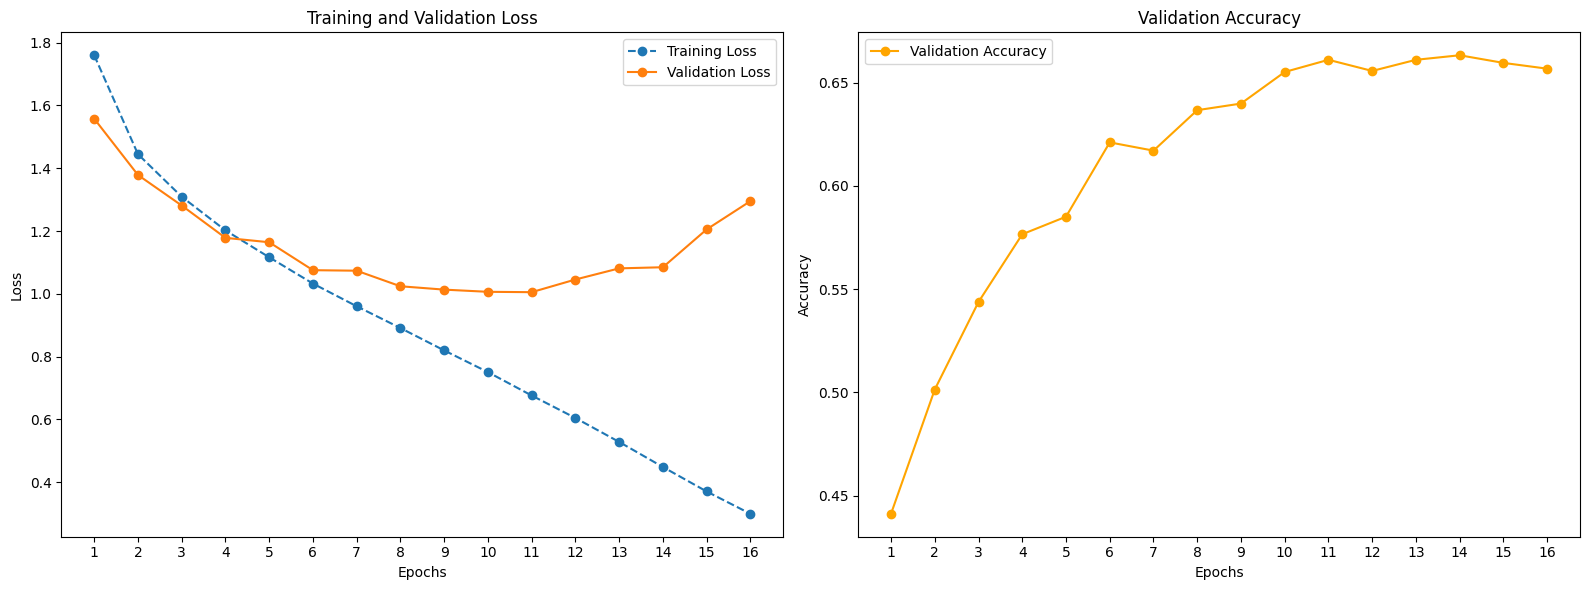

In [56]:
from src.trainer import plot_history

plot_history(history)

In [57]:
trainer.save_model(output_dir="./models", suffix="cifar10_v1")

Model saved to ./models/CNN_cifar10_v1_20250828-153936.pth


'./models/CNN_cifar10_v1_20250828-153936.pth'

In [58]:
# Here we test the model on test data collecting all predictions
model.eval()
y_gt, y_pred = [], []
for it, data in enumerate (testloader):
    x, y = data
    x, y = x.to(device), y.to(device)

    yp = model(x)

    y_pred.append(yp.argmax(1))
    y_gt.append(y)

Accuracy: 65.68 %


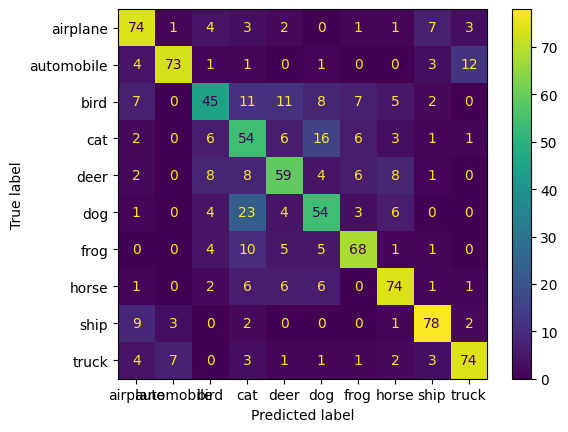

In [59]:
# Here we look at accuracy and confusion matrix
y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
print(f'Accuracy: {accuracy*100:.2f} %')

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)

cmn = (100*cmn).astype(np.int32)
disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
disp.plot()
plt.show()

In [60]:
cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)
print(f'Per class accuracy: {np.diag(cmn).mean():.4f}')

Per class accuracy: 0.6568


In [61]:
for data in testloader:
    x, y = data
    #plt.imshow(x[0,:].permute(1,2,0))
    break

for data in fakeloader:
    xfake, _ = data
    #plt.imshow(x[0,:].permute(1,2,0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.96862745].


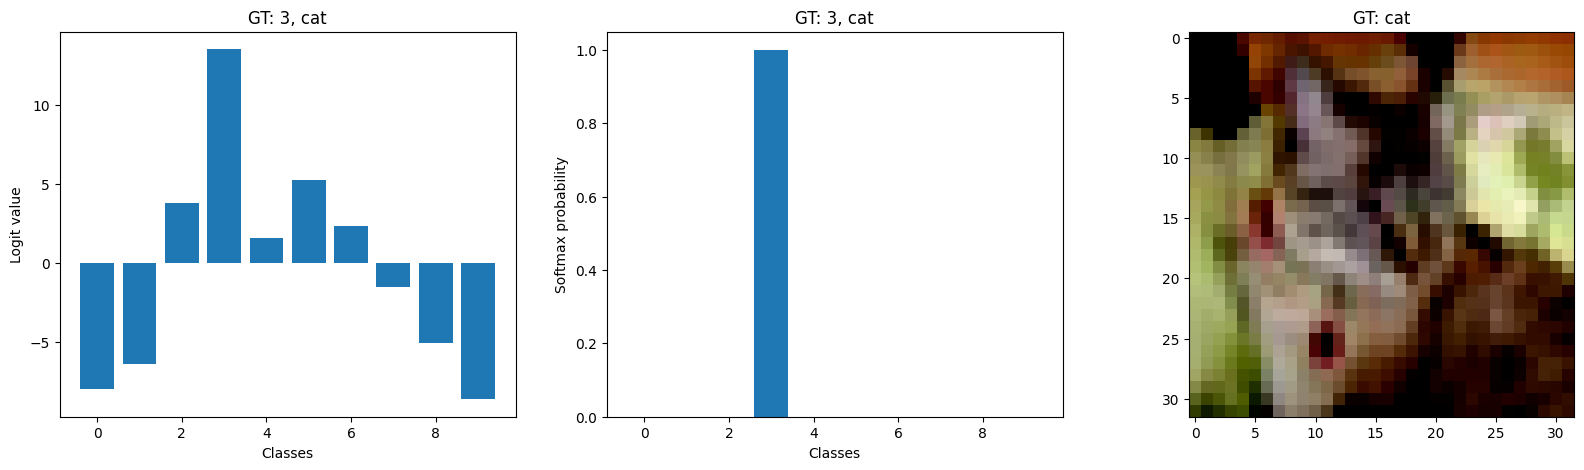

In [69]:
import random
# Example of logit and softmax output
# k=0 # the kth sample of the batch
k = random.randint(0,x.shape[0])
output = model(x.cuda())

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title(f'GT: {y[k]}, {testset.classes[y[k]]}')#the corresponding label
plt.xlabel('Classes')
plt.ylabel('Logit value')

T=1
s = F.softmax(output/T, 1)
plt.subplot(1, 3, 2)
plt.title(f'GT: {y[k]}, {testset.classes[y[k]]}')
plt.bar(np.arange(10),s[k].detach().cpu())
plt.xlabel('Classes')
plt.ylabel('Softmax probability')

plt.subplot(1, 3, 3)
plt.title(f'GT: {testset.classes[y[k]]}')
plt.imshow(x[k,:].permute(1,2,0).cpu())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


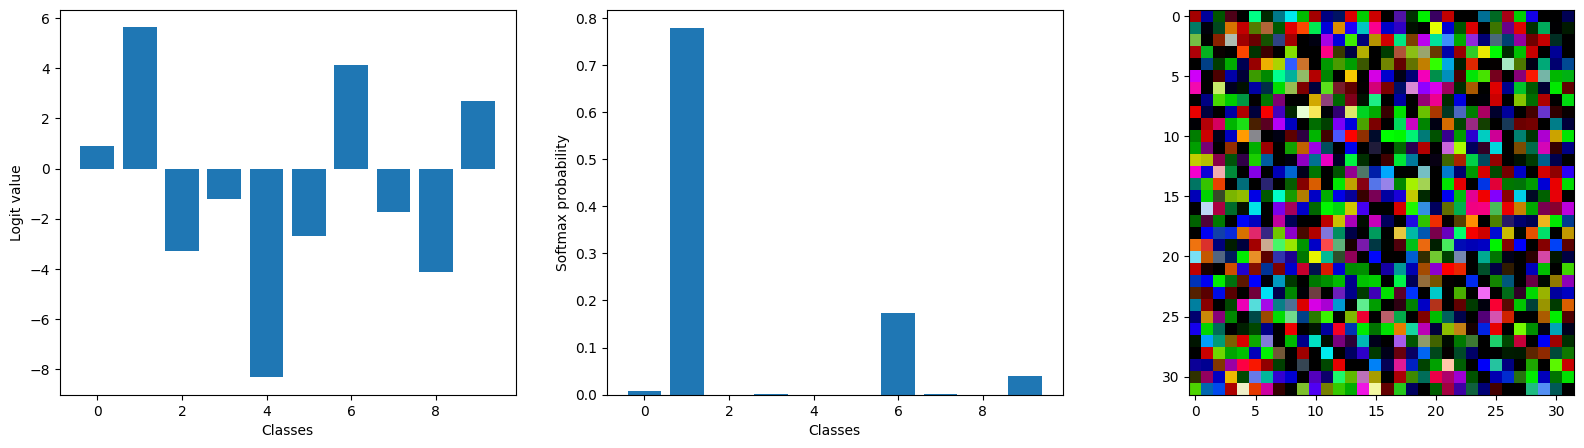

In [70]:
output = model(xfake.cuda())

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.bar(np.arange(10),output[k].detach().cpu())
#plt.title(f'GT: {y[k]}, {testset.classes[y[k]]}')#the corresponding label
plt.xlabel('Classes')
plt.ylabel('Logit value')

T=1
s = F.softmax(output/T, 1)
plt.subplot(1, 3, 2)
#plt.title(f'GT: {y[k]}, {testset.classes[y[k]]}')
plt.bar(np.arange(10),s[k].detach().cpu())
plt.xlabel('Classes')
plt.ylabel('Softmax probability')

plt.subplot(1, 3, 3)
#plt.title(f'GT: {testset.classes[y[k]]}')
plt.imshow(xfake[k,:].permute(1,2,0).cpu())
plt.show()

In [17]:
from src.OOD_detection import CNN

# CNN loading
model = CNN().to(device)
model.load_state_dict(torch.load('./models/CNN_cifar10_v1_20250828-153936.pth'))

/tmp/ipykernel_2083441/3254905046.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/CNN_cifar10_v1_20250828-153936.pth'))


<All keys matched successfully>

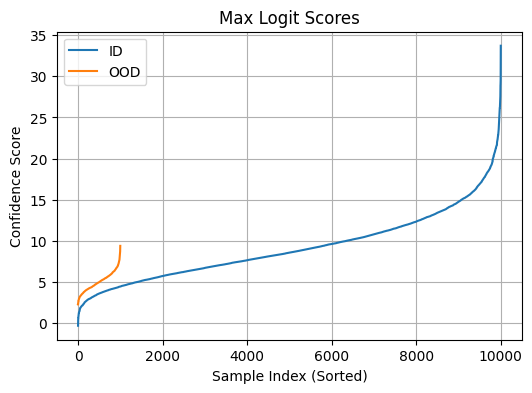

In [18]:
def max_logit(logit):
    s = logit.max(dim=1)[0] #get the max for each element of the batch
    return s

def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    s = s.max(dim=1)[0] #get the max for each element of the batch
    return s


def compute_scores(data_loader, score_fun):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_fun(output)
            scores.append(s)
        scores_t = torch.cat(scores)
        return scores_t

temp = 1
#scores_test = compute_scores(testloader, lambda l: max_softmax(l, T=temp))
#scores_fake = compute_scores(fakeloader, lambda l: max_softmax(l, T=temp))

scores_test = compute_scores(testloader, max_logit)
scores_fake = compute_scores(fakeloader, max_logit)

plt.figure(figsize=(6,4))      
plt.plot(sorted(scores_test.cpu()),label='ID')
plt.plot(sorted(scores_fake.cpu()),label='OOD')
plt.title(f"Max Logit Scores")
plt.xlabel("Sample Index (Sorted)")
plt.ylabel("Confidence Score")
plt.grid()
plt.legend()
plt.show()

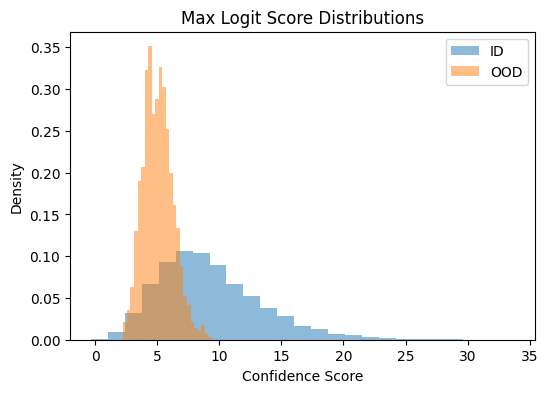

In [65]:
plt.figure(figsize=(6,4)) 
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25,label='ID')
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25,label='OOD')
plt.title("Max Logit Score Distributions")
plt.xlabel("Confidence Score")
plt.ylabel("Density")
plt.legend()
plt.show()

In [8]:
from src.OOD_detection import Autoencoder
#from src.trainer import Trainer, EarlyStopping

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_ae = Autoencoder().to(device)
mse_loss =  nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.0001)


epochs = 20
for e in range(epochs):
    running_loss = 0
    for it, data in enumerate (trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        
        z, x_rec = model_ae(x)
        l = mse_loss(x, x_rec)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        running_loss += l.item()
        #if it % 100 == 0:
        #    print(it, l.item())
    print(e, running_loss/len(trainloader))

0 0.309797820799491
1 0.19766325402595197
2 0.1866677750635635
3 0.17528249289068726
4 0.17080148612446797
5 0.16855828624094843
6 0.16694748721769093
7 0.1656183621767537
8 0.16410608482940117
9 0.1611453138120339
10 0.15911121216728863
11 0.15793817518922068
12 0.15698113397259236
13 0.1561891391987691
14 0.1554535645658098
15 0.15475209106874588
16 0.15418697653524102
17 0.1536584980118915
18 0.15318102608708775
19 0.1527733851957809


In [9]:
model_ae.eval()
#use negative MSE since higher error means OOD
loss = nn.MSELoss(reduction='none')

scores_fake_ae = []
with torch.no_grad():
    for data in fakeloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_fake_ae.append(-score)
        
scores_fake_ae = torch.cat(scores_fake_ae)


scores_test_ae = []
with torch.no_grad():
    for data in testloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_test_ae.append(-score)
        
scores_test_ae = torch.cat(scores_test_ae)

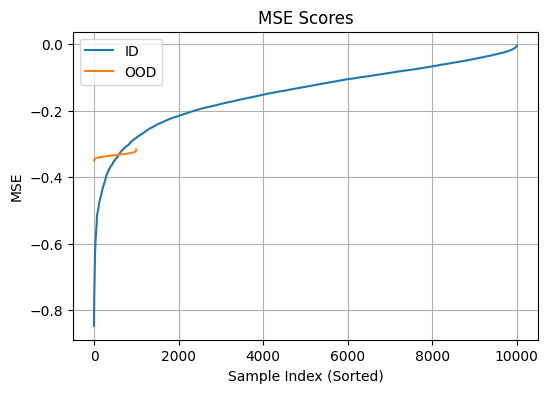

In [11]:
plt.figure(figsize=(6,4))
plt.plot(sorted(scores_test_ae.cpu()), label='ID')
plt.plot(sorted(scores_fake_ae.cpu()), label='OOD')
plt.title(f"MSE Scores")
plt.xlabel("Sample Index (Sorted)")
plt.ylabel("MSE")
plt.grid()
plt.legend()
plt.show()

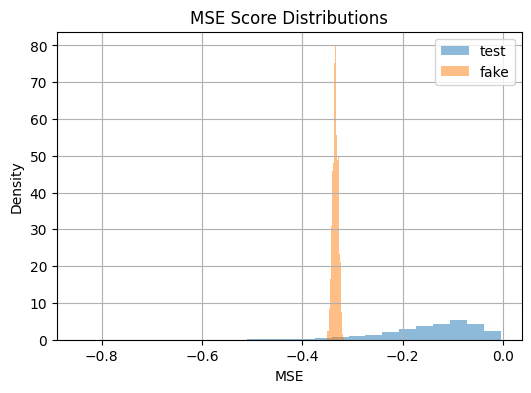

In [13]:

plt.figure(figsize=(6,4))
plt.hist(scores_test_ae.cpu(), density=True, alpha=0.5, bins=25, label='test')
plt.hist(scores_fake_ae.cpu(), density=True, alpha=0.5, bins=25, label='fake')
plt.title(f"MSE Score Distributions")
plt.xlabel("MSE")
plt.ylabel("Density")
plt.grid()
plt.legend()
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



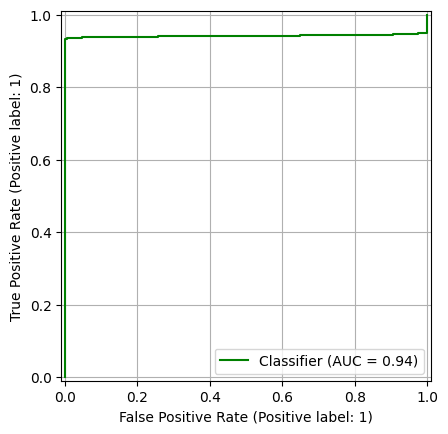

In [14]:
# AE performance
ypred =  torch.cat((scores_test_ae, scores_fake_ae))
y_test = torch.ones_like(scores_test_ae)
y_fake = torch.zeros_like(scores_fake_ae)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu(), color='g')
plt.grid()
plt.show()

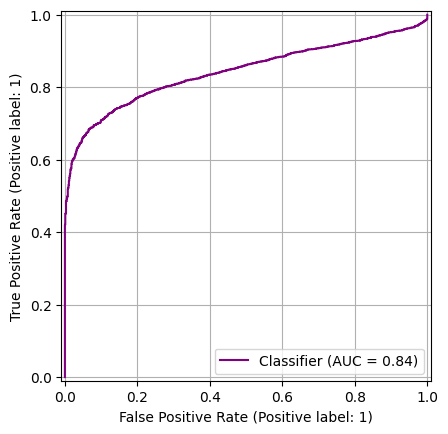

In [19]:
#logits or softmax performance
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu(), color='purple')
plt.grid()
plt.show()

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [14]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = - mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [ ]:
for i,c in enumerate(testset.classes):
    print(i, c)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


/tmp/ipykernel_2083441/3294797781.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/CNN_cifar10_v1_20250828-153936.pth'))
Clippi


--- Untargeted attack ---
Original image class: 'cat'
Untargeted attack succeeded in 1 steps.
Model was fooled! New prediction: 'dog'


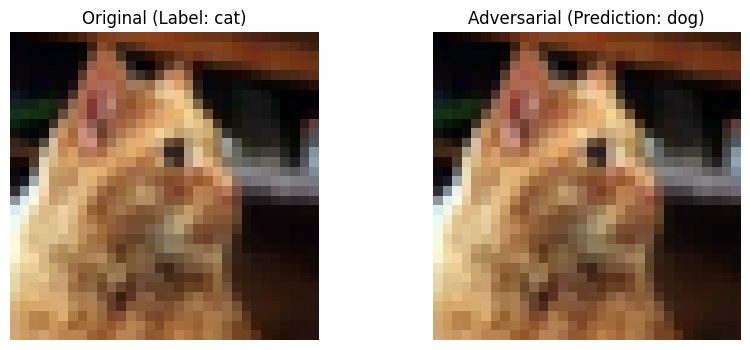

In [26]:
from src.attacker import AdversarialAttackerFGSM 
import matplotlib.pyplot as plt
from src.OOD_detection import CNN
import random

# CNN loading
model = CNN().to(device)
model.load_state_dict(torch.load('./models/CNN_cifar10_v1_20250828-153936.pth'))

loss =  nn.CrossEntropyLoss()
attacker = AdversarialAttackerFGSM (model, loss)

print("\n--- Untargeted attack ---")

idx = random.randint(0, len(testset)-1)
x_original, y_original = testset[idx]
x_original = x_original.unsqueeze(0)
y_original = torch.tensor([y_original])

print(f"Original image class: '{testset.classes[y_original.item()]}'")

# Untargeted attack
x_adv, success, pred = attacker.attack(
    x=x_original, 
    y=y_original,
    epsilon=2/255,
    max_steps=25,
    targeted=False
)

if success:
    print(f"Model was fooled! New prediction: '{testset.classes[pred]}'")
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.imshow(inv(x_original.squeeze(0).cpu()).permute(1, 2, 0))
    plt.title(f"Original (Label: {testset.classes[y_original.item()]})")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(inv(x_adv.squeeze(0).cpu()).permute(1, 2, 0))
    plt.title(f"Adversarial (Prediction: {testset.classes[pred]})")
    plt.axis('off')
    plt.show()



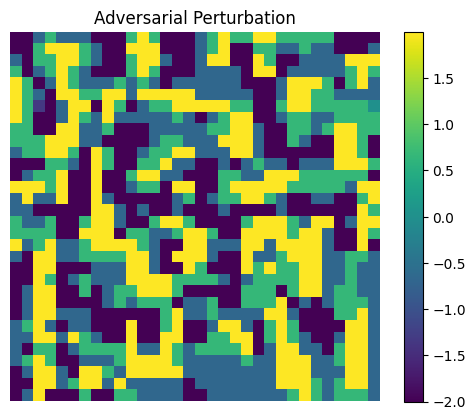

In [37]:
x_adv.to(device)
x_original = x_original.to(device)
diff = x_adv - x_original
diff.squeeze().mean(0).shape
plt.imshow(255*diff.cpu().detach().squeeze().mean(0))
plt.axis('off')
plt.title("Adversarial Perturbation")
plt.colorbar()

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10, FakeData
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [11]:
from src.OOD_detection import CNN
from src.attacker import AdversarialAttackerFGSM
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
robust_model = CNN().to(device) 
optimizer_robust = torch.optim.Adam(robust_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
epsilon = 4/255
#epsilon = 2/255
epochs = 15

attacker = AdversarialAttackerFGSM(robust_model, criterion)

print("Starting adversarial training...")
for e in range(epochs):
    running_loss = 0
    progress_bar = tqdm(trainloader, desc=f"Epoch {e+1}/{epochs}")
    
    for x, y in progress_bar:
        # Data aumentation on-the-fly
        x_adv = attacker.generate_batch_attack(x, y, epsilon=epsilon)
        
        x, y = x.to(device), y.to(device)
        x_combined = torch.cat([x, x_adv])
        y_combined = torch.cat([y, y])
        
        robust_model.train() 
        yp = robust_model(x_combined)
        l = criterion(yp, y_combined)
        
        optimizer_robust.zero_grad()
        l.backward()
        optimizer_robust.step()
        
        running_loss += l.item()
        progress_bar.set_postfix(loss=f"{l.item():.4f}")
        
    print(f"Epoch {e+1}, Average Loss: {running_loss/len(trainloader):.4f}")

print("Adversarial training complete.")

Starting adversarial training...


Epoch 1/15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/15: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s, loss=1.6774]


Epoch 1, Average Loss: 1.8347


Epoch 2/15: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s, loss=1.4350]


Epoch 2, Average Loss: 1.5587


Epoch 3/15: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s, loss=1.4134]


Epoch 3, Average Loss: 1.4413


Epoch 4/15: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s, loss=1.2041]


Epoch 4, Average Loss: 1.3581


Epoch 5/15: 100%|██████████| 391/391 [00:47<00:00,  8.24it/s, loss=1.2582]


Epoch 5, Average Loss: 1.2957


Epoch 6/15: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s, loss=1.1018]


Epoch 6, Average Loss: 1.2349


Epoch 7/15: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s, loss=1.2153]


Epoch 7, Average Loss: 1.1832


Epoch 8/15: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s, loss=1.1265]


Epoch 8, Average Loss: 1.1296


Epoch 9/15: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s, loss=1.0966]


Epoch 9, Average Loss: 1.0804


Epoch 10/15: 100%|██████████| 391/391 [00:47<00:00,  8.24it/s, loss=1.0746]


Epoch 10, Average Loss: 1.0275


Epoch 11/15: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s, loss=0.9558]


Epoch 11, Average Loss: 0.9767


Epoch 12/15: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s, loss=1.0693]


Epoch 12, Average Loss: 0.9233


Epoch 13/15: 100%|██████████| 391/391 [00:47<00:00,  8.24it/s, loss=1.0485]


Epoch 13, Average Loss: 0.8732


Epoch 14/15: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s, loss=0.7024]


Epoch 14, Average Loss: 0.8176


Epoch 15/15: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=0.7830]

Epoch 15, Average Loss: 0.7623
Adversarial training complete.


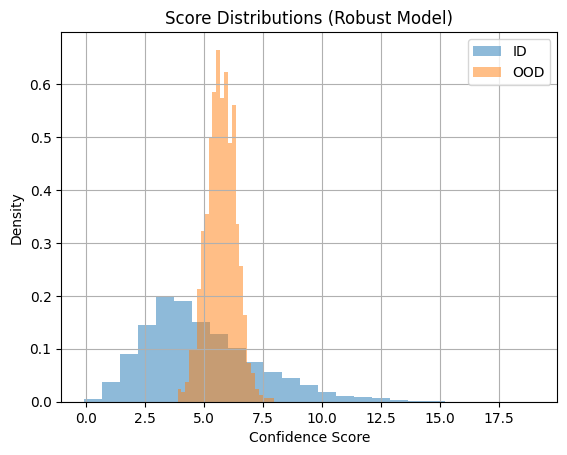

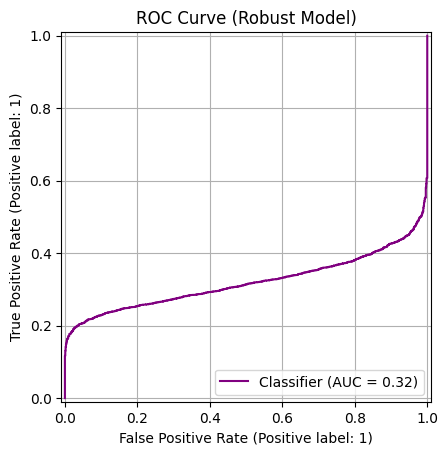

In [12]:
from sklearn import metrics
from src.OOD_detection import max_logit, compute_scores

robust_model.eval()
scores_test_robust = compute_scores(testloader, robust_model, device, max_logit)
scores_fake_robust = compute_scores(fakeloader, robust_model, device, max_logit)


plt.hist(scores_test_robust.cpu(), density=True, alpha=0.5, bins=25, label='ID')
plt.hist(scores_fake_robust.cpu(), density=True, alpha=0.5, bins=25, label='OOD')
plt.title("Score Distributions (Robust Model)")
plt.xlabel("Confidence Score")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

y_pred_robust = torch.cat((scores_test_robust, scores_fake_robust))
y_true_robust = torch.cat((torch.ones_like(scores_test_robust), torch.zeros_like(scores_fake_robust)))

metrics.RocCurveDisplay.from_predictions(y_true_robust.cpu(), y_pred_robust.cpu(), color='purple')
plt.title('ROC Curve (Robust Model)')
plt.grid()
plt.show()

---
## Exercise 3: Wildcard

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00392145..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].




--- Targeted attack ---
Original image class: 'cat'
Target class:'automobile'
Targeted attack succeeded in 3 steps.
Model was fooled! New prediction: 'automobile'


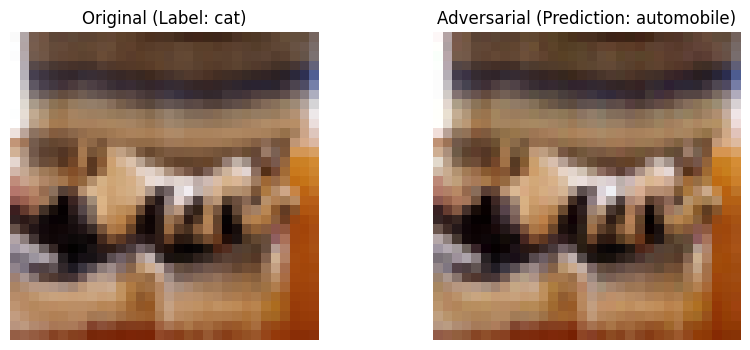

In [17]:
print("\n\n--- Targeted attack ---")
idx = random.randint(0, len(testset)-1)
x_original_2, y_original_2 = testset[idx]
x_original_2 = x_original_2.unsqueeze(0)
y_original_2 = torch.tensor([y_original_2])
target = 1 #'automobile'

print(f"Original image class: '{testset.classes[y_original_2.item()]}'")
print(f"Target class:'{testset.classes[target]}'")


x_adv_2, success_2, pred_2 = attacker.attack(
    x=x_original_2, 
    y=y_original_2,
    epsilon=2/255,
    max_steps=25,
    targeted=True,
    target_label=target
)

if success_2:
    print(f"Model was fooled! New prediction: '{testset.classes[pred_2]}'")
    # Visualizza i risultati
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.imshow(inv(x_original_2.squeeze(0).cpu()).permute(1, 2, 0))
    plt.title(f"Original (Label: {testset.classes[y_original_2.item()]})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(inv(x_adv_2.squeeze(0).cpu()).permute(1, 2, 0))
    plt.title(f"Adversarial (Prediction: {testset.classes[pred_2]})")
    plt.axis('off')
    plt.show()